# Build Gender Classificatio Prototype models

In [1]:
import os
import datetime
import tensorflow as tf
import shutil
import cv2
import imghdr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"otmanheddouch","key":"c77f8d9d542ddf10cdb0a230c627fb89"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
#change the premission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51           9250        301  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           7702        185  1.0              
amaanansari09/top-100-songs                                Top 100 songs                                 6KB  2023-02-16 18:55:35           2351         74  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:2

In [8]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

 89% 241M/269M [00:01<00:00, 215MB/s]
100% 269M/269M [00:01<00:00, 221MB/s]


In [9]:
! mkdir data

In [10]:
! unzip gender-classification-dataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/Validation/male/067031.jpg.jpg  
  inflating: data/Validation/male/067038.jpg.jpg  
  inflating: data/Validation/male/067040.jpg.jpg  
  inflating: data/Validation/male/067046.jpg.jpg  
  inflating: data/Validation/male/067048.jpg.jpg  
  inflating: data/Validation/male/067054.jpg.jpg  
  inflating: data/Validation/male/067064.jpg.jpg  
  inflating: data/Validation/male/067068.jpg.jpg  
  inflating: data/Validation/male/067069.jpg.jpg  
  inflating: data/Validation/male/067086.jpg.jpg  
  inflating: data/Validation/male/067091.jpg.jpg  
  inflating: data/Validation/male/067099.jpg.jpg  
  inflating: data/Validation/male/067101.jpg.jpg  
  inflating: data/Validation/male/067102.jpg.jpg  
  inflating: data/Validation/male/067112.jpg.jpg  
  inflating: data/Validation/male/067117.jpg.jpg  
  inflating: data/Validation/male/067119.jpg.jpg  
  inflating: data/Validation/male/067133.jpg.jpg  
  inflating: data/Validation/ma

In [11]:
import requests

r = requests.get("https://huggingface.co/datasets/myvision/gender-classification/resolve/0436258caffcd200b69e30a2a95c54ebf70e9144/data/train-00000-of-00001.parquet")
open("data.parquet", "wb").write(r.content)

import pyarrow.parquet as pq
table = pq.read_table('data.parquet')

list_image_bytes= []
for i in table["image"]:
  list_image_bytes.append(i["bytes"])

list_label= []
for i in table["label"]:
  list_label.append(i.as_py())


for i,img in enumerate(list_image_bytes):
    if list_label[i] == 0:
        b = img.as_py()
        with open(f'data/Training/female/{i}_.jpg.jpg', 'wb') as f:
            f.write(b)
    else:
        b = img.as_py()
        with open(f'data/Training//male/{i}_.jpg.jpg', 'wb') as f:
            f.write(b)
            i+=1

In [12]:
main_dir = "data/"
# Setup the train and test directories
project_name = "GenderClassification"
train_dir = f"{main_dir}Training/"
test_dir = f"{main_dir}Validation/"
labels = ["female","male"]

In [13]:
# Create walk through directory fonction 
def walk_through_dir(main_dir,folder_name,labels):
    path_ = main_dir + folder_name +"/"+labels[0]
    path = main_dir + folder_name +"/"+labels[1]

    print(f"In the {folder_name} folder  with {labels[0]} class there is {len(os.listdir(path_))} images")
    print(f"In the {folder_name} folder  with {labels[1]} class there is {len(os.listdir(path))} images")    

In [14]:
walk_through_dir(main_dir,"Validation",labels),walk_through_dir(main_dir,"Training",labels),

In the Validation folder  with female class there is 5841 images
In the Validation folder  with male class there is 5808 images
In the Training folder  with female class there is 25792 images
In the Training folder  with male class there is 26217 images


(None, None)

In [15]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    print(f"Image shape: {img.shape}") # show the shape of the image
    return img

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback
def plot_loss_curves(history):
    
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))
  # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

  # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    
def prepare_img(filepath):
    img_ = cv2.imread(filepath)
    resize = tf.image.resize(img_, (224,224))
    return np.expand_dims(resize/255, 0)

def predict(model,filepath):
    image = prepare_img(filepath)
    image1 = mpimg.imread(filepath)
    y_pred = model.predict(image)
    plt.imshow(image1)
    print(y_pred)
    if y_pred > 0.50: 
        print(f'Predicted class is Male')
        plt.title("Male")
    else:
        plt.title("Female")
        print(f'Predicted class is Female')
    plt.show()

Image shape: (224, 224, 3)


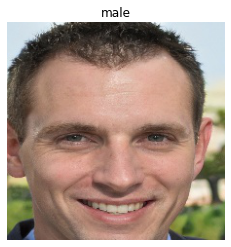

In [16]:
img = view_random_image(train_dir,random.choice(labels))

In [17]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,image_size=(224,224))
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,image_size=(224,224),shuffle=False)

Found 52009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


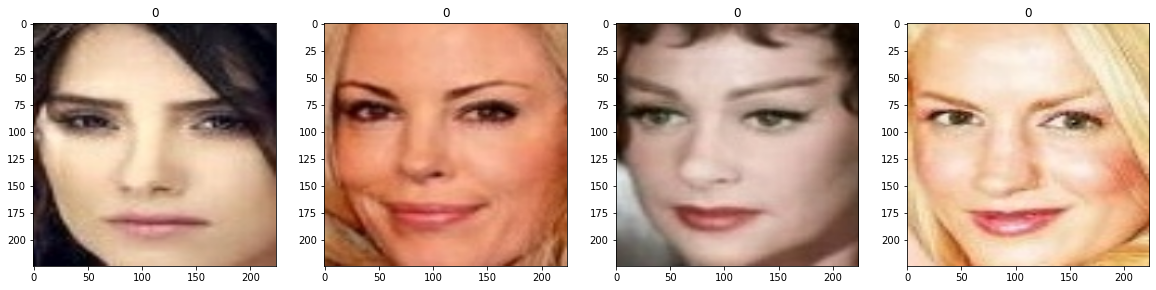

In [19]:
data_iterator = test_data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [20]:
train_data = train_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [22]:
history_1 = model_1.fit(train_data,
          epochs=10,
          callbacks=[create_tensorboard_callback(dir_name="logdir_tensorboard",experiment_name="model_1")],
          validation_data=test_data)

Saving TensorBoard log files to: logdir_tensorboard/model_1/20230307-144246
Epoch 1/10
1626/1626 [==============================] - 104s 56ms/step - loss: 0.3063 - accuracy: 0.8705 - val_loss: 0.2018 - val_accuracy: 0.9255
Epoch 2/10
1626/1626 [==============================] - 102s 62ms/step - loss: 0.2085 - accuracy: 0.9213 - val_loss: 0.1793 - val_accuracy: 0.9332
Epoch 3/10
1626/1626 [==============================] - 96s 59ms/step - loss: 0.1823 - accuracy: 0.9311 - val_loss: 0.1865 - val_accuracy: 0.9294
Epoch 4/10
1626/1626 [==============================] - 75s 46ms/step - loss: 0.1633 - accuracy: 0.9397 - val_loss: 0.1531 - val_accuracy: 0.9431
Epoch 5/10
1626/1626 [==============================] - 75s 46ms/step - loss: 0.1473 - accuracy: 0.9457 - val_loss: 0.1658 - val_accuracy: 0.9403
Epoch 6/10
1626/1626 [==============================] - 75s 46ms/step - loss: 0.1360 - accuracy: 0.9487 - val_loss: 0.1604 - val_accuracy: 0.9403
Epoch 7/10
1626/1626 [========================

In [23]:
model_1.save("model_1.h5")

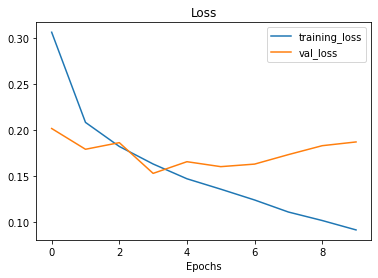

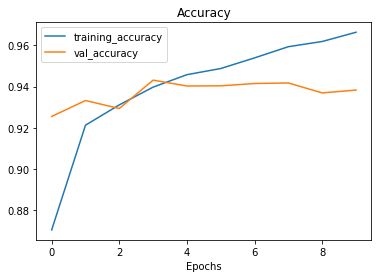

In [24]:
plot_loss_curves(history_1)

In [25]:
model_1.evaluate(test_data)

365/365 [==============================] - 11s 31ms/step - loss: 0.1872 - accuracy: 0.9383


[0.1872478723526001, 0.9382779598236084]

1/1 [==============================] - 0s 191ms/step
[[0.9942841]]
Predicted class is Male


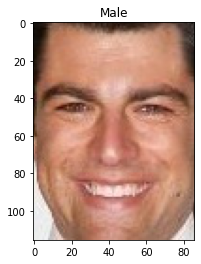

In [26]:
random_class = random.choice(labels)
random_img = random.choice(os.listdir(test_dir+random_class))
img = test_dir+random_class+"/"+random_img
predict(model_1,img)

In [27]:
test_data.as_numpy_iterator().next()[0].shape

(32, 224, 224, 3)

In [ ]:
for i in test_data.unbatch():
  print(i)

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
X,y = (test_data.as_numpy_iterator().next()[0],test_data.as_numpy_iterator().next()[1])
yhat = model_1.predict(X)

pre.update_state(y, yhat.round()[:,0])
re.update_state(y, yhat.round()[:,0])
acc.update_state(y, yhat.round()[:,0])
print("Pre:",pre.result().numpy())
print("re:",re.result().numpy())
print("Acc:",acc.result().numpy())


1/1 [==============================] - 0s 37ms/step
Pre: 0.0
re: 0.0
Acc: 0.96875


In [29]:
import pandas as pd

if not os.path.exists("history"):
  os.makedirs("history")
hist_df = pd.DataFrame(history_1.history)
hist_df.to_csv("history/histiry_1.csv")

In [30]:
y_pred = model_1.predict(test_data)
y_pred.round()[:,0]

365/365 [==============================] - 11s 29ms/step


array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): 
  y_labels.append(labels.numpy()) 
y_labels

In [32]:
len(y_labels)

11649

In [46]:
from sklearn.metrics import classification_report
model_insight_acc = classification_report(y_labels, y_pred.round()[:,0],output_dict=True)

In [50]:
if not os.path.exists("Acc"):
  os.makedirs("Acc")
df_acc_model_1 = pd.DataFrame.from_dict(model_insight_acc)
df_acc_model_1

,0,1,accuracy,macro avg,weighted avg
precision,0.936882,0.939692,0.938278,0.938287,0.938283
recall,0.940250,0.936295,0.938278,0.938272,0.938278
f1-score,0.938563,0.937991,0.938278,0.938277,0.938277
support,5841.000000,5808.000000,0.938278,11649.000000,11649.000000


In [52]:
df_acc_model_1.to_csv("Acc/model_1_acc.csv")

In [51]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(224, 224, 3)), 
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 10)      

In [53]:
history_2 = model_2.fit(train_data,
          epochs=10,
          callbacks=[create_tensorboard_callback(dir_name="logdir_tensorboard",experiment_name="model_2")],
          validation_data=test_data)

Saving TensorBoard log files to: logdir_tensorboard/model_2/20230307-150920
Epoch 1/10
1626/1626 [==============================] - 95s 57ms/step - loss: 0.3095 - accuracy: 0.8655 - val_loss: 0.2050 - val_accuracy: 0.9248
Epoch 2/10
1626/1626 [==============================] - 76s 47ms/step - loss: 0.2197 - accuracy: 0.9158 - val_loss: 0.2034 - val_accuracy: 0.9267
Epoch 3/10
1626/1626 [==============================] - 79s 49ms/step - loss: 0.1985 - accuracy: 0.9264 - val_loss: 0.1690 - val_accuracy: 0.9359
Epoch 4/10
1626/1626 [==============================] - 67s 41ms/step - loss: 0.1828 - accuracy: 0.9326 - val_loss: 0.1613 - val_accuracy: 0.9431
Epoch 5/10
1626/1626 [==============================] - 76s 47ms/step - loss: 0.1717 - accuracy: 0.9362 - val_loss: 0.1546 - val_accuracy: 0.9411
Epoch 6/10
1626/1626 [==============================] - 69s 42ms/step - loss: 0.1633 - accuracy: 0.9400 - val_loss: 0.1581 - val_accuracy: 0.9432
Epoch 7/10
1626/1626 [==========================

In [54]:
model_2.save("model_2.h5")

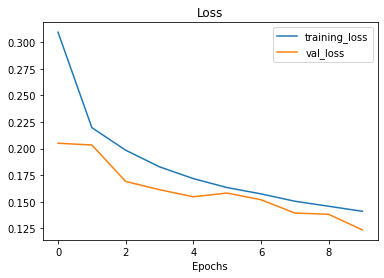

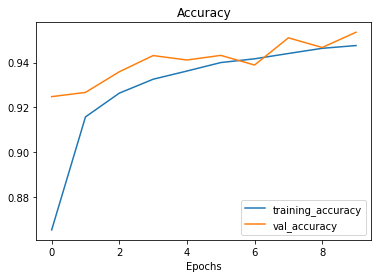

In [55]:
plot_loss_curves(history_2)

In [56]:
model_2.evaluate(test_data)

365/365 [==============================] - 12s 33ms/step - loss: 0.1234 - accuracy: 0.9535


[0.12339712679386139, 0.953472375869751]

1/1 [==============================] - 0s 24ms/step
[[0.17241463]]
Predicted class is Female


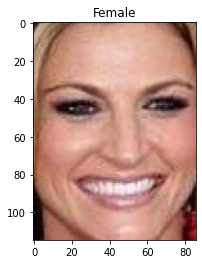

In [66]:
labels = ["female","male"]
random_class = random.choice(labels)
random_img = random.choice(os.listdir(test_dir+random_class))
img = test_dir+random_class+"/"+random_img
predict(model_2,img)

In [67]:
import pandas as pd

if not os.path.exists("history"):
  os.makedirs("history")
hist_df = pd.DataFrame(history_2.history)
hist_df.to_csv("history/histiry_2.csv")

In [68]:
y_pred = model_2.predict(test_data)
y_pred.round()[:,0]

365/365 [==============================] - 12s 33ms/step


array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [69]:
print(classification_report(y_labels, y_pred.round()[:,0]))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5841
           1       0.95      0.96      0.95      5808

    accuracy                           0.95     11649
   macro avg       0.95      0.95      0.95     11649
weighted avg       0.95      0.95      0.95     11649



In [70]:
model_insight_acc = classification_report(y_labels, y_pred.round()[:,0],output_dict=True)
if not os.path.exists("Acc"):
  os.makedirs("Acc")
df_acc_model_2 = pd.DataFrame.from_dict(model_insight_acc)
df_acc_model_2

,0,1,accuracy,macro avg,weighted avg
precision,0.958947,0.948094,0.953472,0.953520,0.953536
recall,0.947783,0.959194,0.953472,0.953489,0.953472
f1-score,0.953332,0.953612,0.953472,0.953472,0.953472
support,5841.000000,5808.000000,0.953472,11649.000000,11649.000000


In [71]:
df_acc_model_2.to_csv("Acc/model_2_acc.csv")

In [72]:
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=100, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(224, 224, 3)), 
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(65, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"), 
  tf.keras.layers.Conv2D(65, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 100)     2800      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 100)    0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 65)      58565     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 65)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 65)        38090     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 65)      

In [73]:
history_3 = model_3.fit(train_data,
          epochs=10,
          callbacks=[create_tensorboard_callback("logdir_tensorboard","model_2")],
          validation_data=test_data)

Saving TensorBoard log files to: logdir_tensorboard/model_2/20230307-152559
Epoch 1/10
1626/1626 [==============================] - 193s 115ms/step - loss: 0.4467 - accuracy: 0.7732 - val_loss: 0.2610 - val_accuracy: 0.8974
Epoch 2/10
1626/1626 [==============================] - 178s 109ms/step - loss: 0.2563 - accuracy: 0.8987 - val_loss: 0.2002 - val_accuracy: 0.9247
Epoch 3/10
1626/1626 [==============================] - 186s 114ms/step - loss: 0.2135 - accuracy: 0.9170 - val_loss: 0.1679 - val_accuracy: 0.9362
Epoch 4/10
1626/1626 [==============================] - 177s 109ms/step - loss: 0.1901 - accuracy: 0.9269 - val_loss: 0.1553 - val_accuracy: 0.9420
Epoch 5/10
1626/1626 [==============================] - 177s 109ms/step - loss: 0.1757 - accuracy: 0.9326 - val_loss: 0.1528 - val_accuracy: 0.9408
Epoch 6/10
1626/1626 [==============================] - 185s 114ms/step - loss: 0.1639 - accuracy: 0.9376 - val_loss: 0.1468 - val_accuracy: 0.9454
Epoch 7/10
1626/1626 [==============

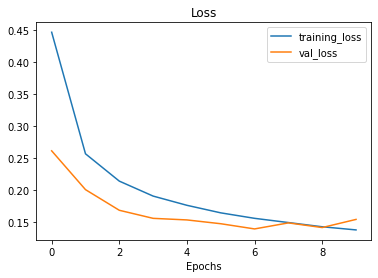

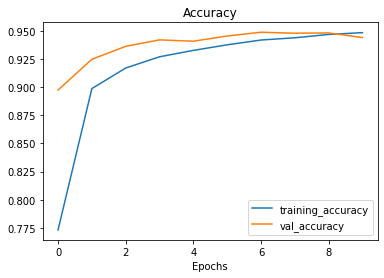

In [74]:
plot_loss_curves(history_3)

1/1 [==============================] - 0s 104ms/step
[[0.02438509]]
Predicted class is Female


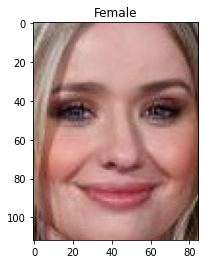

In [75]:
labels = ["female","male"]
random_class = random.choice(labels)
random_img = random.choice(os.listdir(test_dir+random_class))
img = test_dir+random_class+"/"+random_img
predict(model_3,img)

In [76]:
model_3.save("model_3.h5")

In [77]:
model_3.evaluate(test_data)

365/365 [==============================] - 13s 34ms/step - loss: 0.1536 - accuracy: 0.9440


[0.1535874456167221, 0.9440295100212097]

In [78]:
import pandas as pd

if not os.path.exists("history"):
  os.makedirs("history")
hist_df = pd.DataFrame(history_3.history)
hist_df.to_csv("history/histiry_3.csv")

In [79]:
y_pred = model_3.predict(test_data)
y_pred.round()[:,0]

365/365 [==============================] - 13s 36ms/step


array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [80]:
model_insight_acc = classification_report(y_labels, y_pred.round()[:,0],output_dict=True)
if not os.path.exists("Acc"):
  os.makedirs("Acc")
df_acc_model_3 = pd.DataFrame.from_dict(model_insight_acc)
df_acc_model_3

,0,1,accuracy,macro avg,weighted avg
precision,0.920843,0.970095,0.94403,0.945469,0.945399
recall,0.971923,0.915978,0.94403,0.943950,0.944030
f1-score,0.945694,0.942260,0.94403,0.943977,0.943982
support,5841.000000,5808.000000,0.94403,11649.000000,11649.000000


In [82]:
df_acc_model_3.to_csv("Acc/model_3_acc.csv")

In [86]:
history_df_1 =pd.read_csv("history/histiry_1.csv")
history_df_2 =pd.read_csv("history/histiry_2.csv")
history_df_3 =pd.read_csv("history/histiry_3.csv")

In [ ]:
history_df_1

In [90]:
def plot_acc_curves(acc1,label1,acc2,label2,acc3,label3,title):
    
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    epochs = range(len(acc1))
  # Plot loss
    plt.plot(epochs, acc1, label=label1)
    plt.plot(epochs, acc2, label=label2)
    plt.plot(epochs, acc3, label=label3)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.legend()

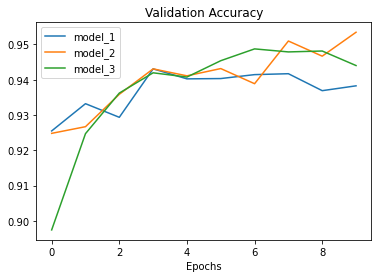

In [94]:
plot_acc_curves(history_df_1["val_accuracy"],"model_1",
                history_df_2["val_accuracy"],"model_2",
                history_df_3["val_accuracy"],"model_3",
                "Validation Accuracy")

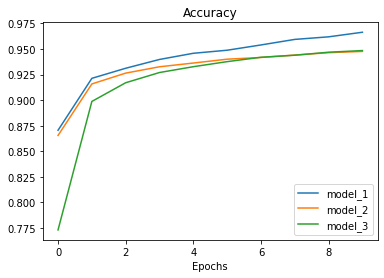

In [95]:
plot_acc_curves(history_df_1["accuracy"],"model_1",
                history_df_2["accuracy"],"model_2",
                history_df_3["accuracy"],"model_3",
                "Accuracy")